In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import random
import string
import matplotlib.pyplot as plt
import json

import nltk
from nltk.tokenize import word_tokenize

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.metrics import precision_recall_curve
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import cohen_kappa_score
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

from yellowbrick.classifier import ROCAUC


import gensim.downloader as api

import warnings
warnings.filterwarnings("ignore")

nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('gutenberg')


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)

[nltk_data] Downloading package punkt to /Users/umer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /Users/umer/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


# Read Data

In [2]:
all_books_names = list(map(lambda x: x.replace('.txt', ''), nltk.corpus.gutenberg.fileids()))
all_books_names

['austen-emma',
 'austen-persuasion',
 'austen-sense',
 'bible-kjv',
 'blake-poems',
 'bryant-stories',
 'burgess-busterbrown',
 'carroll-alice',
 'chesterton-ball',
 'chesterton-brown',
 'chesterton-thursday',
 'edgeworth-parents',
 'melville-moby_dick',
 'milton-paradise',
 'shakespeare-caesar',
 'shakespeare-hamlet',
 'shakespeare-macbeth',
 'whitman-leaves']

## choose books

In [3]:
all_books_names = ["bible-kjv", "whitman-leaves", "chesterton-ball", "austen-emma", "milton-paradise"]

# Helper functions

In [407]:
def process_one_book(book_corpus, partions_num=None, clean_it=True, words_num=100, random_partions=False):
    '''
    Process one book by split it to partions, where each partition contains $words_num of words,
    then return $partions_num of different partions.
    args:
      - book_corpus     (str)  -> list contains the book's corpus as words.
      - partions_num    (int)  -> number of partitions that will be returned, 
                                  note that if no enough words exist,
                                  it will return the max possible number of partitions.
      - clean_it        (bool) -> if True, will apply clean first.
      - words_num       (int)  -> number of words per partion.
      - random_partions (bool) -> get $partions_num of partitions randomly or from the whole partitions,
                                  of Fale, it will return them sequentially.

    output:
      - out (list) -> list of partions as list of strings.
    '''

    if clean_it:
        book_corpus = clean( book_corpus ).split(' ')


    num_of_possible_partions = len(book_corpus) // words_num
    
    if partions_num:
        max_num_of_partions = min(partions_num, num_of_possible_partions)
    else:
        max_num_of_partions = num_of_possible_partions
    
    partions = [ ' '.join(book_corpus[ i*words_num : i*words_num + words_num]) for i in range(num_of_possible_partions)]

    if random_partions:
        random.shuffle(partions)
                
    return partions[:max_num_of_partions]



def clean(txt):
    '''
    Elminate any non word character from the input text, and remove any additionl spaces.
    
    Args:
      - txt (string) -> the unclean text.
    '''
    txt = re.sub(r'\W', ' ', txt)
    txt = re.sub(r' \w ', ' ', txt)
    txt = re.sub(r' +', ' ', txt)
    return txt.strip().lower()


def processText(text):   
    doc = nlp(text)
    lemma_list = [str(token.lemma_) for token in doc]
    
    #Filter the stopword
    filtered_sentence =[] 
    for word in lemma_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    
    #Remove punctuation
    punctuations = set(["?", ":", "!", ".", ",", ";"])
    filtered_sentence = [word for word in filtered_sentence if word not in punctuations]

    return ' '.join(filtered_sentence).strip()



def plotRegions(model, X, ax=None):
    """
    Plot meshgrid for given @model to differentiate between each class region.

    Args:
        @model (obj)        : The trained model.
        @X     (np matrix)  : The dataset matrix.
        @ax    (matplot ax) : This is the axis of fig, in case of subplot specification.
    """
    if ax == None:
        fig, ax = plt.subplots()
        
    margin = .4
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    XX, YY = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    ZZ = z.reshape(XX.shape)
    ax.contourf(XX, YY, ZZ, alpha=0.2)
    
    
def plotData(X, Y, labels, ax=None, title=None, colors=None, markers=None):
    """
    Plot Dataset as scatter plot.

    Args:
        @X       (np matrix)  : The dataset matrix.
        @Y       (np array)   : Has the truth values for each instance.
        @labels  (list)       : List of the real name of each class.
        @ax      (matplot ax) : This is the axis of fig, in case of subplot specification.
        @title   (str)        : The figuer's title.
        @colors  (list)       : List of custmized colors.
        @markers (list)       : List of custmized markers.
    """
        
    if ax == None: fig, ax = plt.subplots()
    
    if not colors:
        colors = list(mcolors.TABLEAU_COLORS.values())[:len(labels)]
    if not markers:
        markers = list(Line2D.markers.keys())
    
    for index, label in enumerate(labels):
        ax.scatter(
            x=X[Y == index][:,0],
            y=X[Y == index][:,1],
            c=colors[index],
            marker=markers[index],
            label=labels[index]
        )
    
    if title == None: title = "Dataset with {n} classes".format(n=int(len(labels)))
    ax.set_title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend()
    

def getAccuracy(y, y_pred):
    """
    Get the accuracy of given @y and @y_pred.

    Args:
        @y      (list)   : Has the truth values for each instance.
        @y_pred (list)   : Has the predicted values for each instance.
    
    Returns:
        The calculated accuracy.
    """
    acc = accuracy_score(y, y_pred)
    print(f"acc :: {acc}")
    return acc
    

def getF1_cross_val(model, x, y, cv):
    """
    Calculate the F1-score after applying Cross-Validation on @model using the given @x and @y.
    
    Args:
        @model  (obj)       : The trained model.
        @x      (np matrix) : The dataset matrix.
        @y      (list)      : Has the truth values for each instance.
        @cv     (int)       : Number of K-folds.
    
    Returns:
        the calculated F1-score.
    """
    scores = cross_val_score(model, x, y, cv=cv, scoring='f1_macro')
    print("Cross-Validation :: %0.2f avg-f1-score" % (scores.mean()))
    return scores


def getAccReport(y, y_pred, labels):
    """
    Calculate the F1-score, Precision and recall for each class.    
    
    Args:
        @y      (list) : Has the truth values for each instance.
        @y_pred (list) : Has the predicted values for each instance.
        @labels (list) : List of the real name of each class.
    """
    print(classification_report(y, y_pred, target_names=labels))
    
    
    
def plotConfMat(y, y_pred, labels, errorAnalysis=False):
    """
    Plot the Confusion Matrix and Error-Analysis conf-matx debend on the value of @errorAnalysis.    
    
    Args:
        @y      (list)        : Has the truth values for each instance.
        @y_pred (list)        : Has the predicted values for each instance.
        @labels (list)        : List of the real name of each class.
        @errorAnalysis (bool) : To swap between ErrorAnalysis and regular conf-matx.
    """
    
    conf_mx = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7, 4))
    if errorAnalysis:
        print('Error Analysis')
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_confx_mx = conf_mx / row_sums
        # replace all TP with zeros
        np.fill_diagonal(norm_confx_mx, 0)

        ax = sns.heatmap(norm_confx_mx, annot=True, cmap='Blues')
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=45)
        plt.show()
    else:
        ax = sns.heatmap(conf_mx, annot=True, cmap='Blues', fmt='d')
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=45)
        plt.show()
            
    
def plotLearningCurve(model, ax=None):
    """
    Plot learning Curve for the given @model.

    Args:
        @model (obj)        : The trained model.
        @ax    (matplot ax) : This is the axis of fig, in case of subplot specification.
    """
    losses = model.loss_curve_
    
    if ax == None:
        fig, ax = plt.subplots()
            
    ax.plot(range(1, len(losses)+1), losses)
    # add axis labels to plot
    ax.set_title('Learning Curve')
    ax.set_xlabel('#-epochs')
    ax.set_ylabel('loss')

    
def getModelReport(model, x, y, labels):
    """
    get Full report for the given @model.

    Args:
        @model  (obj)       : The trained model.
        @x      (np matrix) : The dataset matrix.
        @y      (list)      : Has the truth values for each instance.
        @labels (list)      : List of the real name of each class.
    """
    
    print("model : ")
    
    y_pred = model.predict(x)
    # get the accuracy of trained model
    getAccuracy(y, y_pred)
        
    getAccReport(y, y_pred, labels)
        
    plotConfMat(y, y_pred, labels)
    
    plotConfMat(y, y_pred, labels, errorAnalysis=True)
      
#     plt.figure(figsize=(10, 8))
#     fig, ax = plt.subplots()
#     plotRegions(model, x, ax=ax)
#     plotData(x, y, labels, ax=ax)
    
    #plot learning curve if the model has losses_
    try:
        plotLearningCurve(model)
    except:
        pass
    
    
def plotProbabilityDis(y_probs, y, labels, ax=None):
    """
    Plot Probability Distribution for each class on same figure to illustrate the overlapping.

    Args:
        @y       (list)        : Has the truth values for each instance.
        @y_probs (list)        : Has the predicted probabilities for each instance.
        @labels  (list)        : List of the real name of each class.
        @ax      (matplot ax)  : This is the axis of fig, in case of subplot specification.
    """
    if ax == None:
        fig, ax = plt.subplots()
        
    colors = list(mcolors.TABLEAU_COLORS.values())[:len(labels)]

    for indx, label in enumerate(labels):
        ax.hist(y_probs[y == indx], 20, density = True, 
            histtype ='bar',
            color = colors[indx],
            label = label)
        
    ax.set_title(f'{labels[0]} vs {labels[1]}')
    ax.legend([f"Class 0: {labels[0]}", f"Class 1: {labels[1]}"])
    ax.set_xlabel(f"P(x = {labels[1]})")
    
    
def plotROC(y_probs, y, labels, model_name, ax=None):
    """
    Plot ROC curve and get AUC.

    Args:
        @y          (list)        : Has the truth values for each instance.
        @y_probs    (list)        : Has the predicted probabilities for each instance.
        @labels     (list)        : List of the real name of each class.
        @model_name (str)         : The label of figure.
        @ax         (matplot ax)  : This is the axis of fig, in case of subplot specification.
    """
    if ax == None:
        fig, ax = plt.subplots()
            
    ns_probs = np.zeros(len(y))
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    ax.plot(ns_fpr, ns_tpr, linestyle='--')
    
    fpr, tpr, _ = roc_curve(y, y_probs)
    ax.plot(fpr, tpr, marker='.', label=model_name)
    
    # get AUC
    auc = round(roc_auc_score(y, y_probs), 2)
    
    ax.set_title(f"ROC Curve with AUC :: {auc}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    
def plotPercesionRecall(y, y_probs, ax=None):
    """
    Plot the percesion and Recall plot.  
    
    Args:
        @y       (list)       : Has the truth values for each instance.
        @y_probs (list)       : Has the predicted probabilities for each instance.
        @ax      (matplot ax) : This is the axis of fig, in case of subplot specification.
    """
    if ax == None:
        fig, ax = plt.subplots()
            
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    ax.plot(recall, precision)
    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    
    
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        try:
            return X.todense()
        except:
            return X
    
    
class CustomVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model=None):
        self.model = model
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array(list(map(lambda x: self._vectorizeSentence(x) , X)))
        
    def _vectorizeSentence(self, sent):
        vect = self.model.vectors_for_all(word_tokenize(sent)).vectors
        if vect.shape[0] == 0: return np.zeros(vect.shape[1])    
        return np.sum(np.array(vect), axis=0)
    
    
# TSNE(perplexity=40, n_components=2, init='pca')
def plotPragraphSpace(X, Y, VecAlgo, custom=False):
    dim_red_algos = {
                  "LDA" : LinearDiscriminantAnalysis(n_components=2),
                  "PCA" : PCA(n_components=2),
                  "T-SNE" : TSNE(n_components=2, learning_rate='auto', init='random', random_state=43),
                  "UMAP" : umap.UMAP(),
                }
    
    if custom:
        VecAlgo = CustomVectorizer(model=VecAlgo)
    
    pip = Pipeline([
            ('vect', VecAlgo),
            ('to_dense', DenseTransformer()),
        ])
    pip.fit(X, Y)
    new_x = pip.transform(X)

    plt.figure(figsize = (25, 15)) 
    for i, key in enumerate(dim_red_algos.keys()):

        dim_algo = dim_red_algos[key]

        ax = plt.subplot(2, 2, i+1)

        try:
            new_x_redu = dim_algo.fit_transform(new_x, y_train)
        except:
            new_x_redu = dim_algo.fit_transform(new_x)

        colors = list(mcolors.TABLEAU_COLORS.values())[:len(set(y_train))]
        for i, clas in enumerate(set(y_train)):
            x = new_x_redu[y_train == clas][:, 0]
            y = new_x_redu[y_train == clas][:, 1]
            ax.scatter(x, y, c=colors[i], label=clas)
        ax.set_title(key)
        plt.legend()
        
        
def plotClusterSpace(X, y_true, y_predict):
    plt.figure(figsize = (25, 7)) 
    
    ax = plt.subplot(1, 2, 1)    
    colors = list(mcolors.TABLEAU_COLORS.values())
    for i, clas in enumerate(set(y_true)):
        x = X[y_true == clas][:, 0]
        y = X[y_true == clas][:, 1]
        ax.scatter(x, y, c=colors[i], label=clas)
    ax.set_title("y_true")
    plt.legend()
    
    
    ax = plt.subplot(1, 2, 2)
    for i, clas in enumerate(set(y_predict)):
        x = X[y_predict == clas][:, 0]
        y = X[y_predict == clas][:, 1]
        ax.scatter(x, y, c=colors[i], label=clas)
    ax.set_title("y_predict")
    
    plt.legend()
    

def plotConfMat2(y, y_pred, true_labels, predict_labels):
    
    conf_mx = confusion_matrix(y, y_pred)[:,:len(set(y_pred))]
    plt.figure(figsize=(7, 4))
    ax = sns.heatmap(conf_mx, annot=True, cmap='Blues', fmt='d')
    ax.xaxis.set_ticklabels(predict_labels)
    ax.yaxis.set_ticklabels(true_labels)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=45)
    plt.show()

In [493]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)

#### All those books are fiction books, so they have the different genres

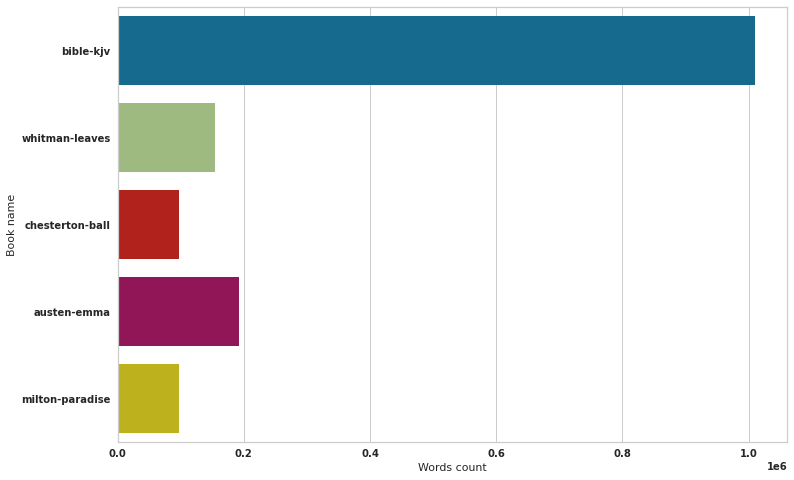

In [494]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y=all_books_names, x=[ len(nltk.corpus.gutenberg.words(f'{book_name}.txt')) for book_name in all_books_names])
plt.xlabel('Words count')
plt.ylabel('Book name')
plt.savefig('books_words_counts.png', bbox_inches='tight')

In [495]:
# prepare data frame
data = [{"content": nltk.corpus.gutenberg.raw(f'{book_name}.txt'),
         "book_name": book_name } for book_name in all_books_names]

data_df = pd.DataFrame(data)
data_df.head()

,content,book_name
0,[The King James Bible]\n\nThe Old Testament of...,bible-kjv
1,[Leaves of Grass by Walt Whitman 1855]\n\n\nCo...,whitman-leaves
2,[The Ball and The Cross by G.K. Chesterton 190...,chesterton-ball
3,[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAP...,austen-emma
4,[Paradise Lost by John Milton 1667] \n \n \nBo...,milton-paradise


# Data Cleaning & Preprocessing

In [496]:
corpus = data_df.content.str.cat(sep=' ')
set(re.findall(r'[^\w ]', corpus))

{'\n',
 '\x1a',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '>',
 '?',
 '@',
 '[',
 ']',
 '`',
 '}',
 '~'}

In [497]:
apply_clean = True
words_num = 150
random_partions = True
partions_num = 200
all_books_df = pd.DataFrame()

In [498]:
for book in all_books_names:
    # get each book partions
    book_partions = process_one_book( data_df[data_df.book_name == book].content.iloc[0],
                                      partions_num=partions_num,
                                      clean_it=apply_clean,
                                      words_num=words_num,
                                      random_partions=random_partions)
    
    # create DF for that book
    book_df = pd.DataFrame({'partions': book_partions, 'label': [ book ]*len(book_partions) })
    all_books_df = all_books_df.append(book_df, ignore_index=True)

In [499]:
all_books_df

,partions,label
0,and smote certain of them and plucked off thei...,bible-kjv
1,granted repentance unto life 11 19 now they wh...,bible-kjv
2,him not 36 and they were all amazed and spake ...,bible-kjv
3,he goeth these were redeemed from among men be...,bible-kjv
4,were pure and killed the passover for all the ...,bible-kjv
...,...,...
995,conception children thou shalt bring in sorrow...,milton-paradise
996,nor on my part single in me all posterity stan...,milton-paradise
997,own inventions hope things not revealed which ...,milton-paradise
998,argued fear each on himself relied as only in ...,milton-paradise


<Figure size 864x576 with 0 Axes>

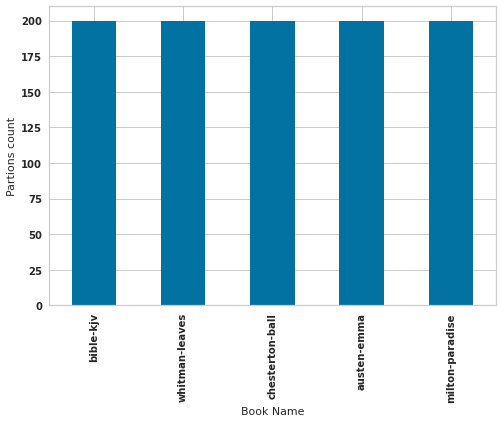

In [500]:
plt.figure(figsize=(12, 8))
fig, ax = plt.subplots()
all_books_df.label.value_counts().plot(ax=ax, kind='bar', xlabel='numbers', ylabel='frequency')
plt.xlabel('Book Name')
plt.ylabel('Partions count')
plt.savefig('partions_counts.png', bbox_inches='tight')

## Clean, Remove stop-words and Steeming

In [501]:
# clean
all_books_df['cleaned_partions'] = all_books_df.partions.apply(clean)

In [502]:
# Remove stop words 
all_stopwords = nlp.Defaults.stop_words
remove_stop_words = lambda x: ' '.join([word for word in word_tokenize(x) if not word in all_stopwords])

all_books_df['partions_without_stop_words'] = all_books_df.partions.apply(remove_stop_words)

In [503]:
# Steem words
all_books_df['steemed_partions'] = all_books_df.partions.apply(processText)

In [504]:
all_books_df.head()

,partions,label,cleaned_partions,partions_without_stop_words,steemed_partions
0,and smote certain of them and plucked off thei...,bible-kjv,and smote certain of them and plucked off thei...,smote certain plucked hair swear god saying ye...,smote certain pluck hair swear god ye shall da...
1,granted repentance unto life 11 19 now they wh...,bible-kjv,granted repentance unto life 11 19 now they wh...,granted repentance unto life 11 19 scattered a...,grant repentance unto life 11 19 scatter abroa...
2,him not 36 and they were all amazed and spake ...,bible-kjv,him not 36 and they were all amazed and spake ...,36 amazed spake saying word authority power co...,36 amazed spake word authority power commandet...
3,he goeth these were redeemed from among men be...,bible-kjv,he goeth these were redeemed from among men be...,goeth redeemed men firstfruits unto god lamb 1...,goeth redeem man firstfruit unto god lamb 14 m...
4,were pure and killed the passover for all the ...,bible-kjv,were pure and killed the passover for all the ...,pure killed passover children captivity brethr...,pure kill passover child captivity brother pri...


Text(0, 0.5, '# of partions')

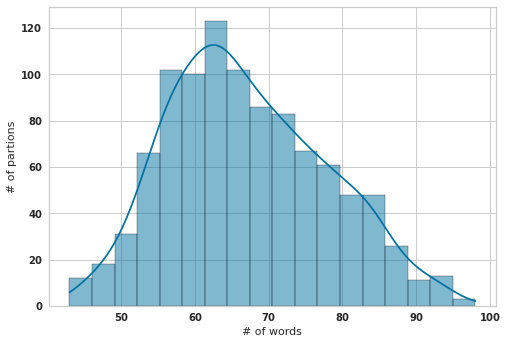

In [505]:
x = all_books_df.steemed_partions.apply(lambda x: len(x.split()))
sns.histplot(data=all_books_df, x=x, kde=True)
plt.xlabel("# of words")
plt.ylabel("# of partions")

Text(0.5, 0, '# of words')

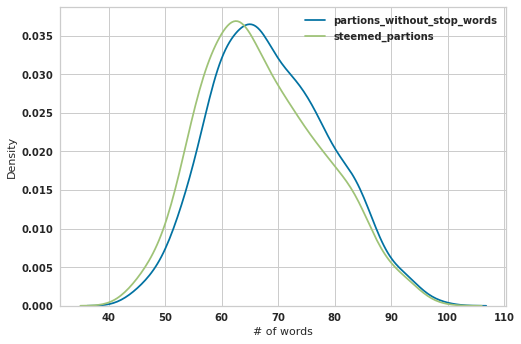

In [506]:
x = all_books_df.partions_without_stop_words.apply(lambda x: len(x.split()))
sns.kdeplot(x, label='partions_without_stop_words')
x = all_books_df.steemed_partions.apply(lambda x: len(x.split()))
sns.kdeplot(x, label='steemed_partions')
plt.legend()
plt.xlabel('# of words')

In [507]:
from collections import Counter
word_cloud = []
df_res = {}
for bn in all_books_df.label.unique():
    book1 = clean(all_books_df.steemed_partions[all_books_df.label == bn].str.cat(sep=" "))
    book1_counter = Counter(clean(book1).split(' '))
    word_cloud.append((bn, {i[0]: i[1] for i in book1_counter.most_common(10)}))
    df_res[bn] = [i[0] for i in book1_counter.most_common(10)]

# Most common words for each book

In [508]:
from wordcloud import WordCloud
import ipywidgets
from IPython.core.pylabtools import figsize

def wordBook (bookList =[] ):
    if len(bookList) > 0 :
        B1 = bookList[0][1]
        drop_Down = ipywidgets.Dropdown(options = bookList  , value = B1 , description= 'book')
        def updateWordCloud (choice):
            wordcloud = WordCloud(colormap="tab20").generate_from_frequencies(choice)
            plt.figure(figsize=(8,8))
            plt.imshow(wordcloud)
            plt.axis('off')
        ipywidgets.interact(updateWordCloud , choice = drop_Down)
    else:
        print('plz send u book list')

In [509]:
wordBook(word_cloud)

interactive(children=(Dropdown(description='book', options=(('bible-kjv', {'shall': 335, 'unto': 316, 'lord': …

In [510]:
pd.DataFrame(df_res)

,bible-kjv,whitman-leaves,chesterton-ball,austen-emma,milton-paradise
0,shall,man,turnbull,mr,thy
1,unto,shall,macian,emma,thou
2,lord,come,man,think,heaven
3,thy,night,like,mrs,shall
4,man,day,come,miss,thee
5,god,old,thing,weston,god
6,come,life,look,know,man
7,son,soul,know,harriet,earth
8,king,love,think,good,high
9,thee,face,evan,thing,son


In [511]:
X_train, y_train = all_books_df.steemed_partions, all_books_df.label

# Transformation and Embeding

In [23]:
max_df = 0.7

### 1- BOW

In [24]:
BOW = CountVectorizer()

### 2- TF-IDF

In [25]:
TFIDF = TfidfVectorizer(stop_words='english', max_df=max_df)

### 3-BOW-n-gram

In [26]:
BOW_NGRAM = CountVectorizer(stop_words='english', ngram_range=(2,2), max_df=max_df)

### 4- TF-IDF-n-gram

In [27]:
TFIDF_NGRAM = TfidfVectorizer(stop_words='english', ngram_range=(2,2), max_df=max_df)

### 5- glove

In [28]:
glove = api.load("glove-wiki-gigaword-300")

### 6- word2vec

In [29]:
word2vec = api.load("word2vec-google-news-300")

### 7- FastTxt

In [30]:
fastTxt = api.load("fasttext-wiki-news-subwords-300")

# Check which Dimensionality reduction algorithm works well with which Embedding way.

##### Dimensionality reduction Algorithems that will be check "LDA" & "PCA" & "T-SNE" & "UMAP"

## BOW

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


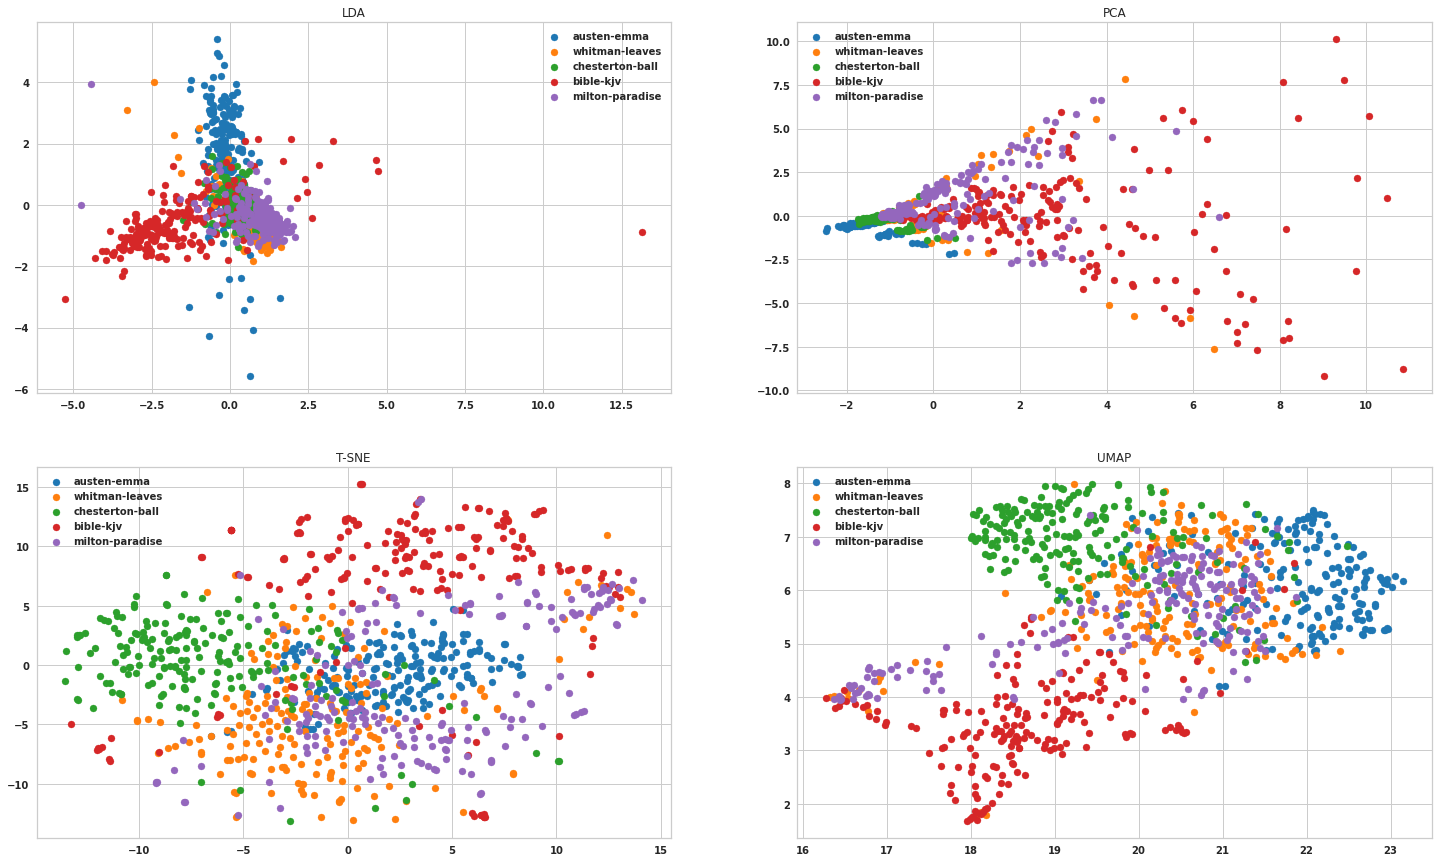

In [31]:
plotPragraphSpace(X_train, y_train, BOW)

# TF-IDF

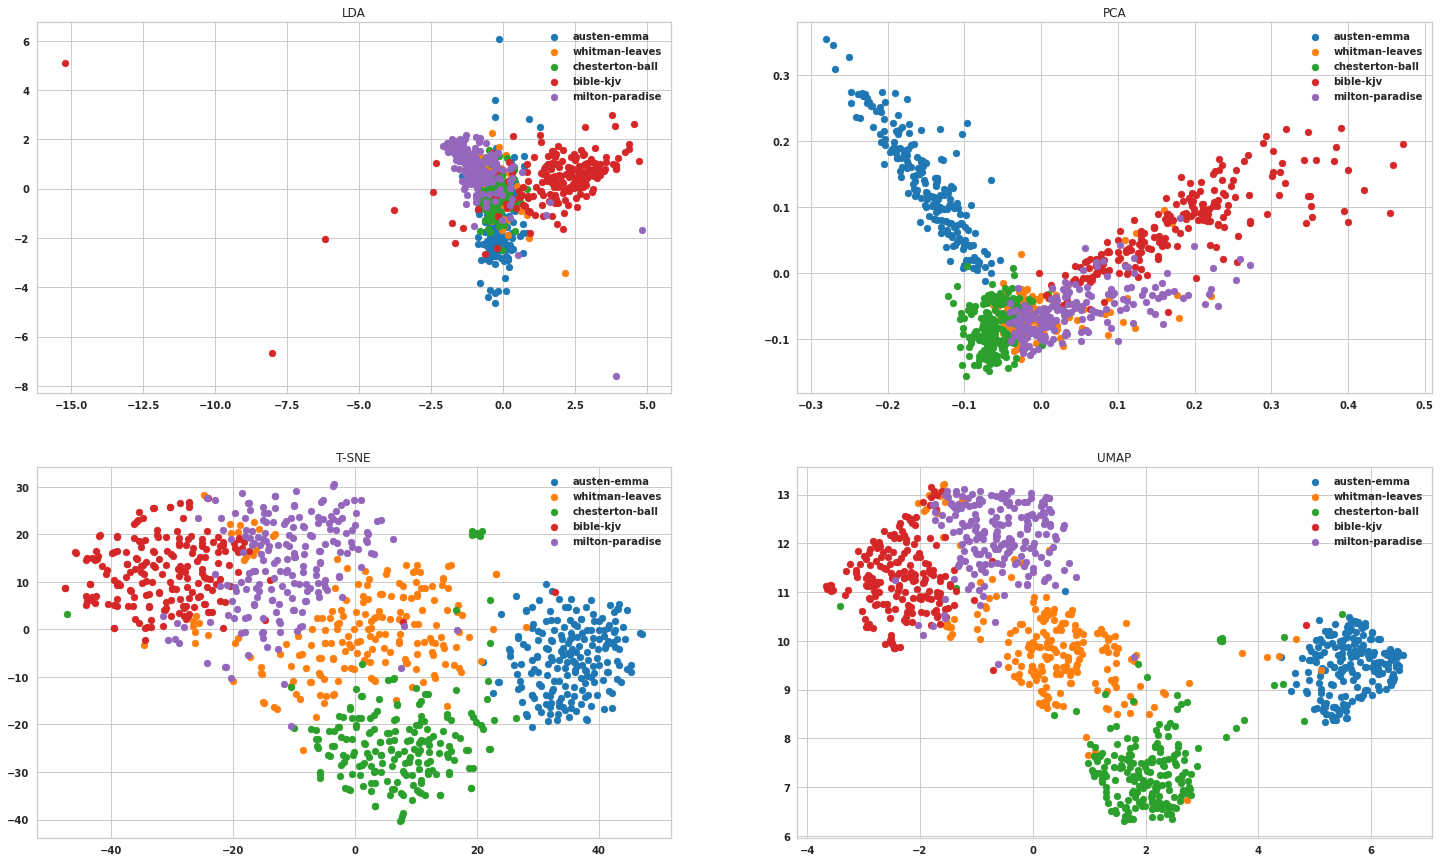

In [32]:
plotPragraphSpace(X_train, y_train, TFIDF)

## BOW-n-gram

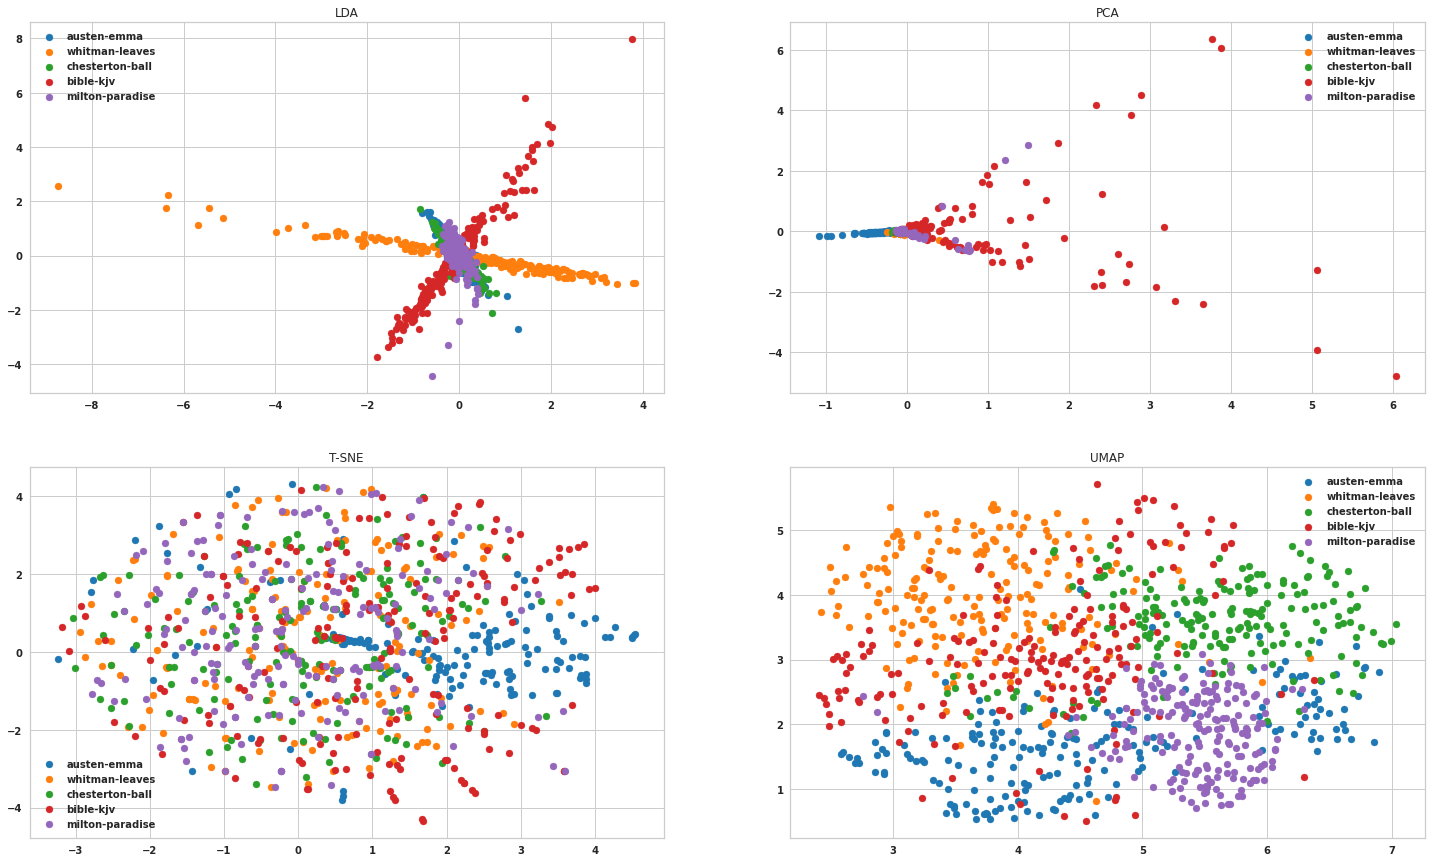

In [33]:
plotPragraphSpace(X_train, y_train, BOW_NGRAM)

## TFIDF-n-gram

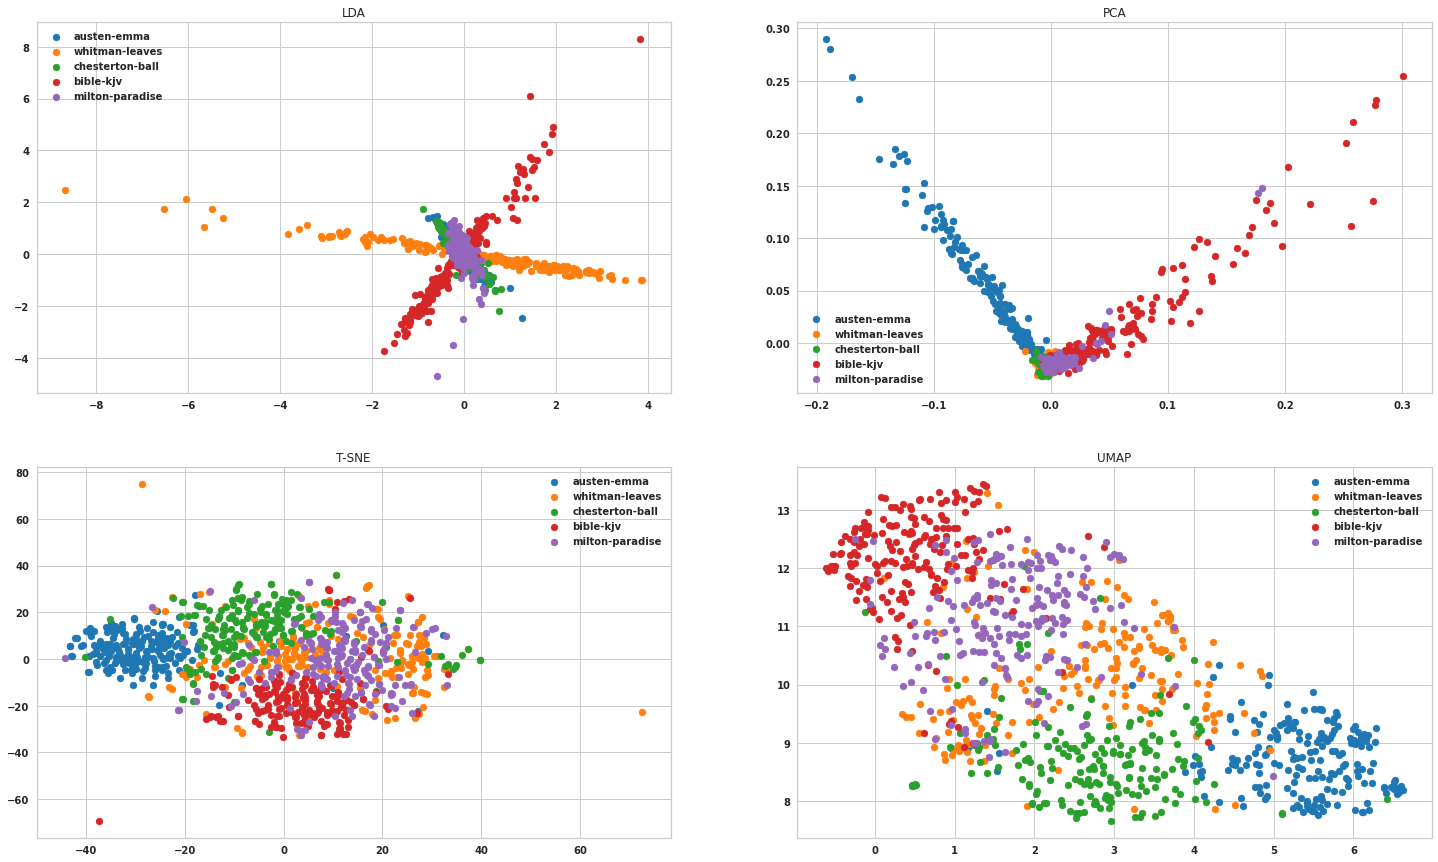

In [34]:
plotPragraphSpace(X_train, y_train, TFIDF_NGRAM)

## Glove

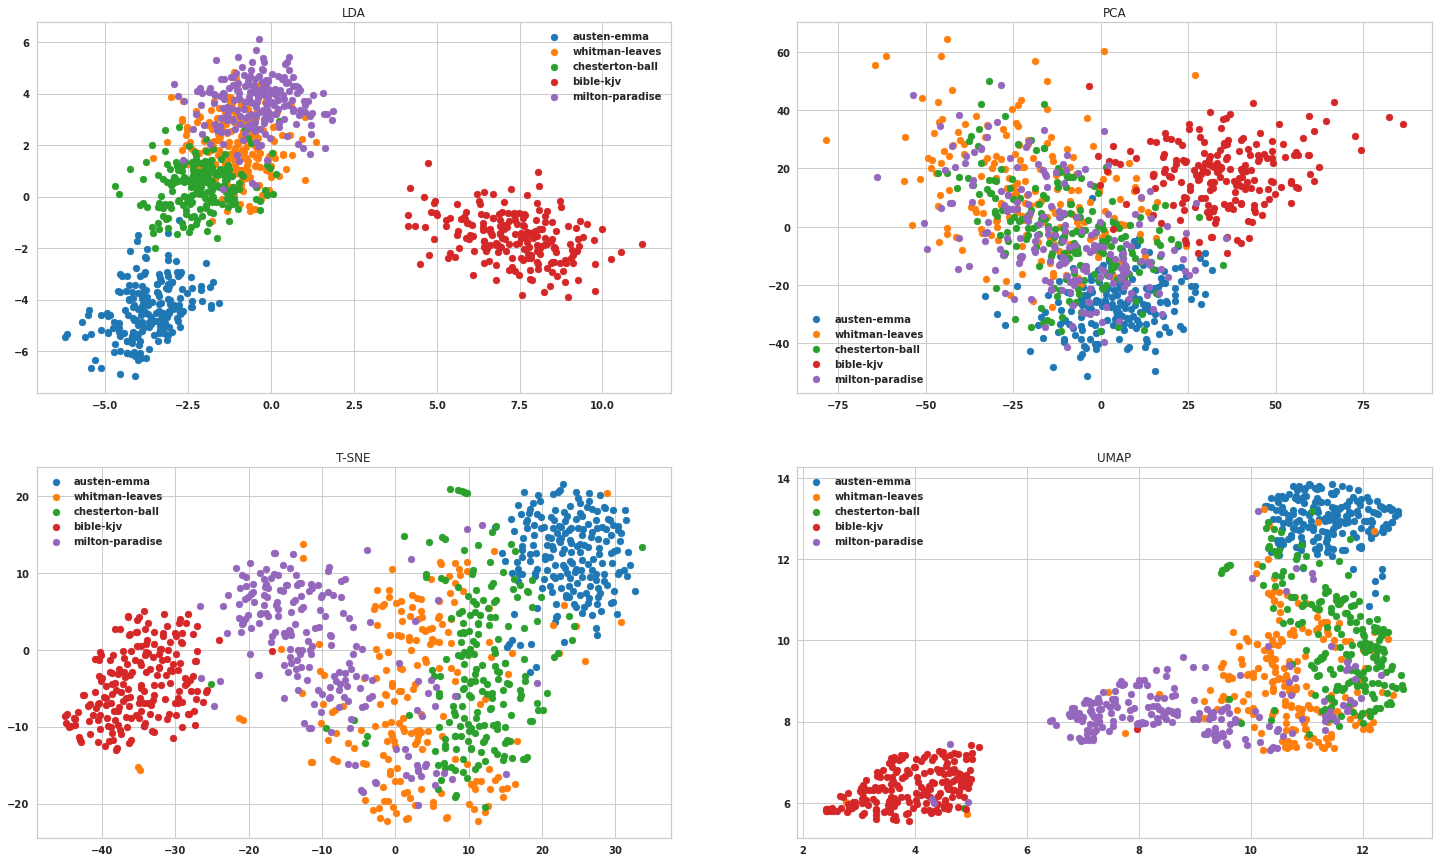

In [35]:
plotPragraphSpace(X_train, y_train, glove, custom=True)

## Word2Vec

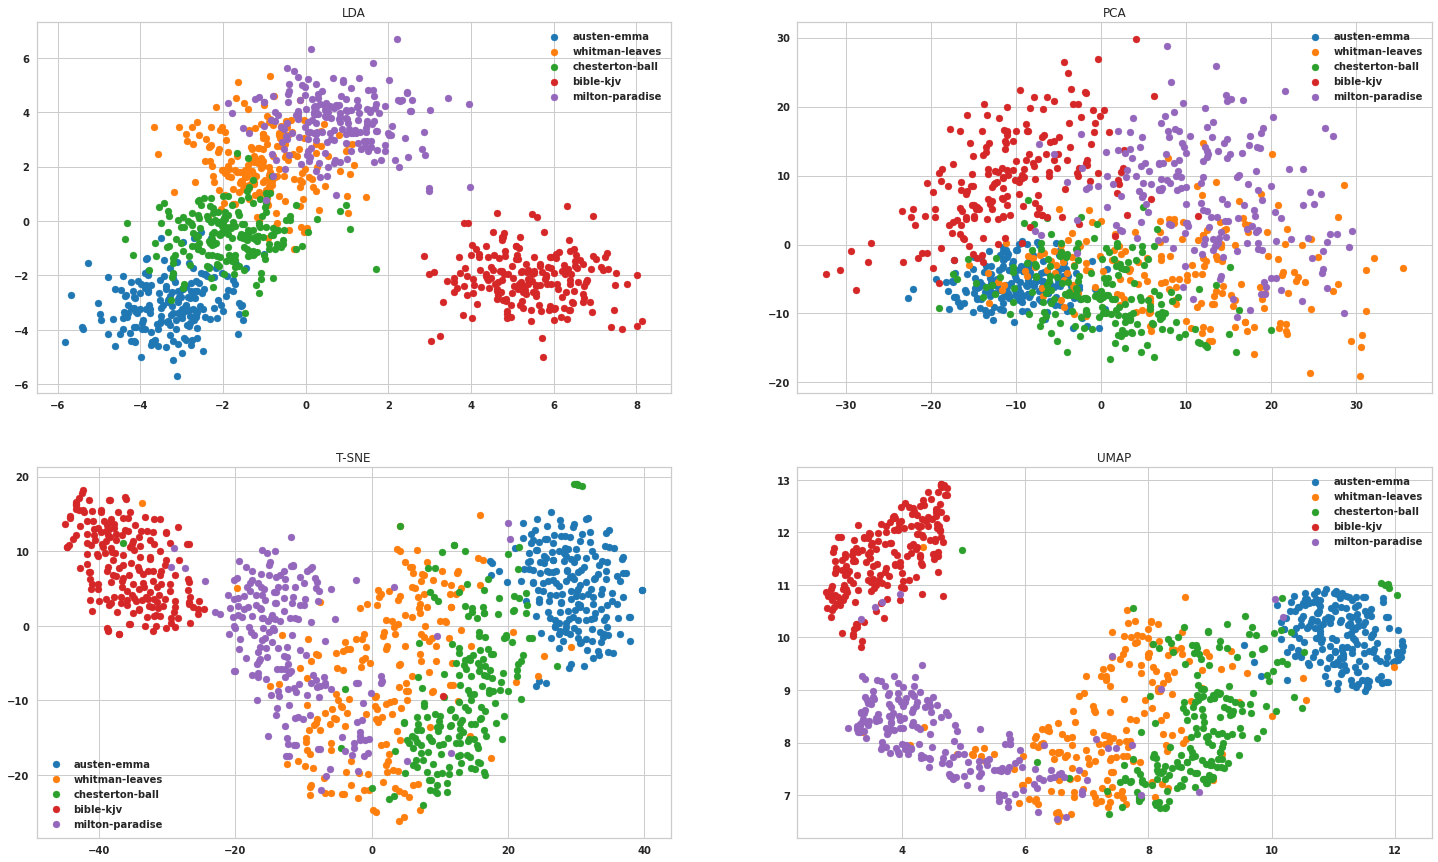

In [36]:
plotPragraphSpace(X_train, y_train, word2vec, custom=True)

## FastTxt

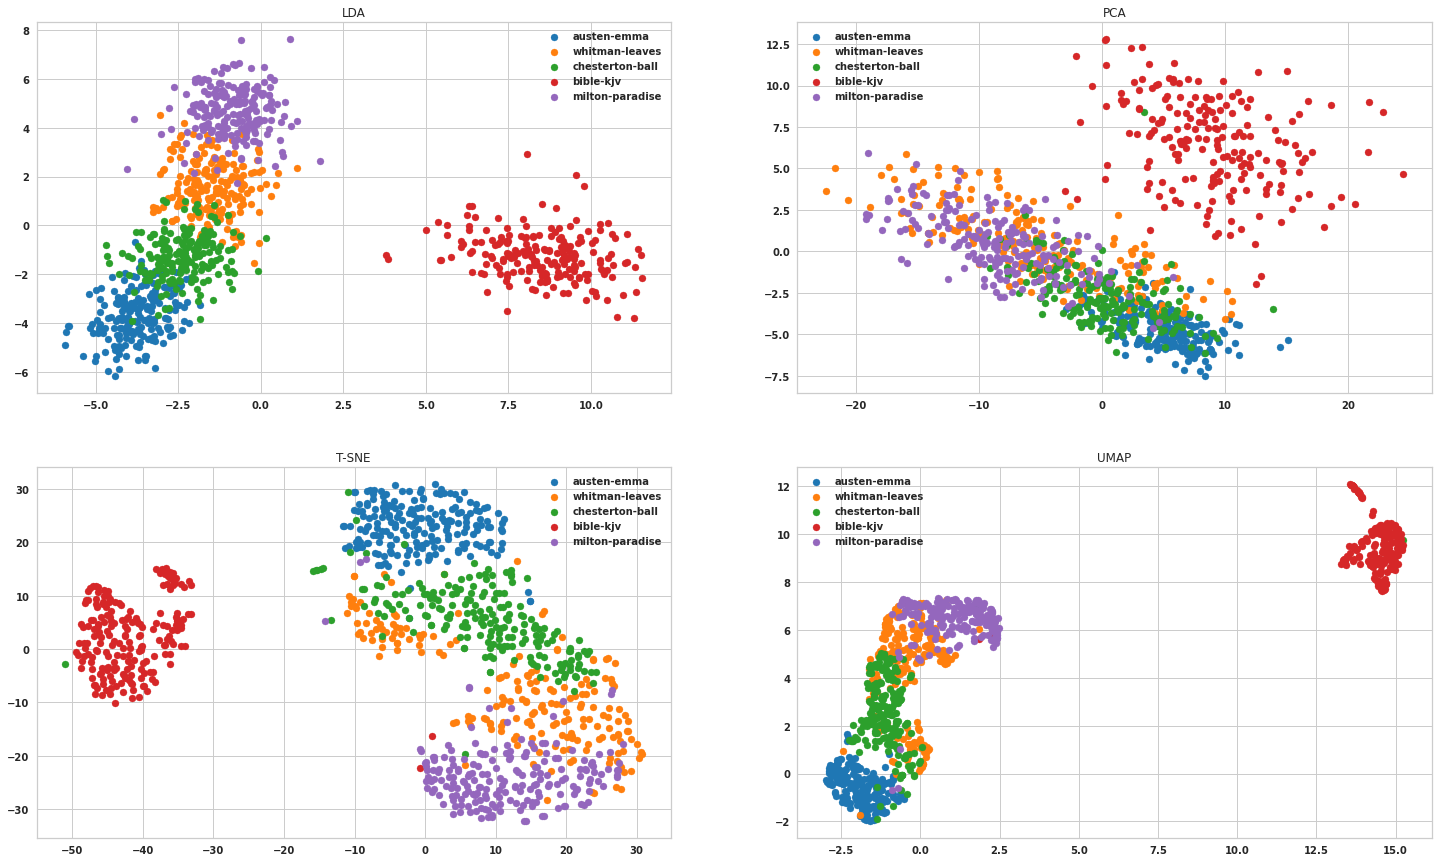

In [37]:
plotPragraphSpace(X_train, y_train, fastTxt, custom=True)

## we have checked the Clustering Separability visually between each Embedding technique and 4 dimensionality reduction algorithms, and our conclusion is that **U-MAP** is the best in separating the clusters with the occurrence of embedding techniques, but **LDA** is the best for contextual embedding teqniques, but because we need to deal with the absent y_true case (unknown), so we will apply UMAP for all of them, also to fit the memory.
* U-MAP will use with { BOW, TF-IDF, BOW-n-gram, Tf-IDF-n-gram, Glove, Word2vec, FastTxt}

# Apply Clustering

In [269]:
k_range = (2,11)
dim_red = umap.UMAP(n_components=10, random_state=40)
experments = {
                "bow_umap": (BOW, dim_red),
                "tfidf_umap": (TFIDF, dim_red),
                "bow-n-gram_umap": (BOW_NGRAM, dim_red),
                "tfidf-n-gram_umap": (TFIDF_NGRAM, dim_red),
                "glove_umap": (CustomVectorizer(model=glove), dim_red),
                "word2vec_umap": (CustomVectorizer(model=word2vec), dim_red),
                "fastTxt_umap": (CustomVectorizer(model=fastTxt), dim_red),
             }


# K-means

In [270]:
k_means_resutls = []

for exp_name, vectorizer in experments.items():
    vectorizer, dim_red = vectorizer

    vectorizer_pipline = Pipeline([
            ('vect', vectorizer),
            ('to_dense', DenseTransformer()),
            ('dim_red', dim_red),
#             ('scaller', MinMaxScaler()),
        ])

    new_x_train = vectorizer_pipline.fit_transform(X_train)
    print(f"Start: {exp_name} - {new_x_train.shape}")
    
    # get the elbow with best k
    # choose the best K in for k-means,
    wsse_ = []
    silhouette_scores = []
    calinski_harabasz_scores = []
    kappa = [] 
    
    for i in range(*k_range):
        print(f" --- K={i}")
        kmeans = KMeans(n_clusters = i, random_state = 42 )
        kmeans.fit(new_x_train)
        # wss
        wsse_.append(kmeans.inertia_)
        # silhouette
        silhouette_scores.append(silhouette_score(new_x_train, kmeans.predict(new_x_train)))
        # calinski (Variance Ratio Criterion)
        calinski_harabasz_scores.append(calinski_harabasz_score(new_x_train, kmeans.predict(new_x_train)))

        
        
    knee_wss = KneeLocator(range(*k_range), wsse_, curve='convex', direction='decreasing')
    knee_silhouette = KneeLocator(range(*k_range), silhouette_scores, curve='concave', direction='increasing', S=1)
    knee_calinski = KneeLocator(range(*k_range), calinski_harabasz_scores, curve='concave', direction='increasing', S=1)    
    
    result_ = {"name": f"K-mean-{exp_name}",
               "vec_shape": new_x_train.shape,
               "wsse": wsse_[knee_wss.knee-k_range[0]],
               "best_k_elbow": knee_wss.knee,
               "wsse_": wsse_,
               
               "silhouette": silhouette_scores[knee_silhouette.knee-k_range[0]],
               "best_k_silhouette": knee_silhouette.knee,
               "silhouette_scores": silhouette_scores,
               
               "calinski": calinski_harabasz_scores[knee_calinski.knee-k_range[0]],
               "best_k_calinski": knee_calinski.knee,
               "calinski_harabasz_scores": calinski_harabasz_scores,
               
               "pipline": vectorizer_pipline,
              }

    k_means_resutls.append(result_)
    

Start: bow_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: tfidf_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: bow-n-gram_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: tfidf-n-gram_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: glove_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: word2vec_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: fastTxt_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10


In [271]:
kmean_df = pd.DataFrame(k_means_resutls)
kmean_df

,name,vec_shape,wsse,best_k_elbow,wsse_,silhouette,best_k_silhouette,silhouette_scores,calinski,best_k_calinski,calinski_harabasz_scores,pipline
0,K-mean-bow_umap,"(1000, 10)",762.862366,5,"[1413.2608642578125, 1051.4306640625, 903.4723...",0.500059,2,"[0.500059, 0.391612, 0.37357983, 0.31074712, 0...",1042.547322,2,"[1042.5473216019286, 871.5079145991169, 729.84...","(CountVectorizer(), <__main__.DenseTransformer..."
1,K-mean-tfidf_umap,"(1000, 10)",850.376099,4,"[3081.9404296875, 1325.3323974609375, 850.3760...",0.576124,2,"[0.5761242, 0.5912408, 0.54809535, 0.5389423, ...",3727.280846,5,"[1988.8309473997388, 2970.824565091199, 3269.0...","(TfidfVectorizer(max_df=0.7, stop_words='engli..."
2,K-mean-bow-n-gram_umap,"(1000, 10)",673.701050,5,"[1271.6605224609375, 1027.5523681640625, 819.3...",0.282630,2,"[0.28263018, 0.25222015, 0.28568593, 0.3175742...",407.725894,2,"[407.7258942414298, 370.4636412736578, 393.773...","(CountVectorizer(max_df=0.7, ngram_range=(2, 2..."
3,K-mean-tfidf-n-gram_umap,"(1000, 10)",810.976440,4,"[1656.7099609375, 975.2371826171875, 810.97644...",0.404289,2,"[0.40428865, 0.41900727, 0.3555134, 0.33344328...",1186.523205,3,"[987.8104514435792, 1186.5232049856302, 1017.5...","(TfidfVectorizer(max_df=0.7, ngram_range=(2, 2..."
4,K-mean-glove_umap,"(1000, 10)",923.145996,4,"[3303.1923828125, 1826.2340087890625, 923.1459...",0.633800,2,"[0.63380045, 0.52127767, 0.5625318, 0.49091896...",3966.040685,4,"[2612.7683042822646, 2763.7063984944857, 3966....",(CustomVectorizer(model=<gensim.models.keyedve...
5,K-mean-word2vec_umap,"(1000, 10)",991.435547,4,"[3640.68798828125, 1945.3480224609375, 991.435...",0.603739,2,"[0.60373896, 0.5286942, 0.55148935, 0.51742464...",3856.803810,4,"[2430.968207047302, 2706.949196344028, 3856.80...",(CustomVectorizer(model=<gensim.models.keyedve...
6,K-mean-fastTxt_umap,"(1000, 10)",2078.271484,3,"[7056.34765625, 2078.271484375, 1392.255737304...",0.771957,2,"[0.7719568, 0.6638606, 0.575346, 0.54206485, 0...",8218.903619,3,"[4142.140283366364, 8218.903619172333, 8334.49...",(CustomVectorizer(model=<gensim.models.keyedve...


In [518]:
kmean_df[['name', 'vec_shape', 'wsse', 'best_k_elbow', 'silhouette', 'best_k_silhouette', 'calinski', 'best_k_calinski']]

,name,vec_shape,wsse,best_k_elbow,silhouette,best_k_silhouette,calinski,best_k_calinski
0,K-mean-bow_umap,"(1000, 10)",762.862366,5,0.500059,2,1042.547322,2
1,K-mean-tfidf_umap,"(1000, 10)",850.376099,4,0.576124,2,3727.280846,5
2,K-mean-bow-n-gram_umap,"(1000, 10)",673.701050,5,0.282630,2,407.725894,2
3,K-mean-tfidf-n-gram_umap,"(1000, 10)",810.976440,4,0.404289,2,1186.523205,3
4,K-mean-glove_umap,"(1000, 10)",923.145996,4,0.633800,2,3966.040685,4
5,K-mean-word2vec_umap,"(1000, 10)",991.435547,4,0.603739,2,3856.803810,4
6,K-mean-fastTxt_umap,"(1000, 10)",2078.271484,3,0.771957,2,8218.903619,3


## FastText Embedding with UMAP dimensionality reduction got the highest **silhouette**, **calinski** and lowest **wsse**, and the majority voting is K=3

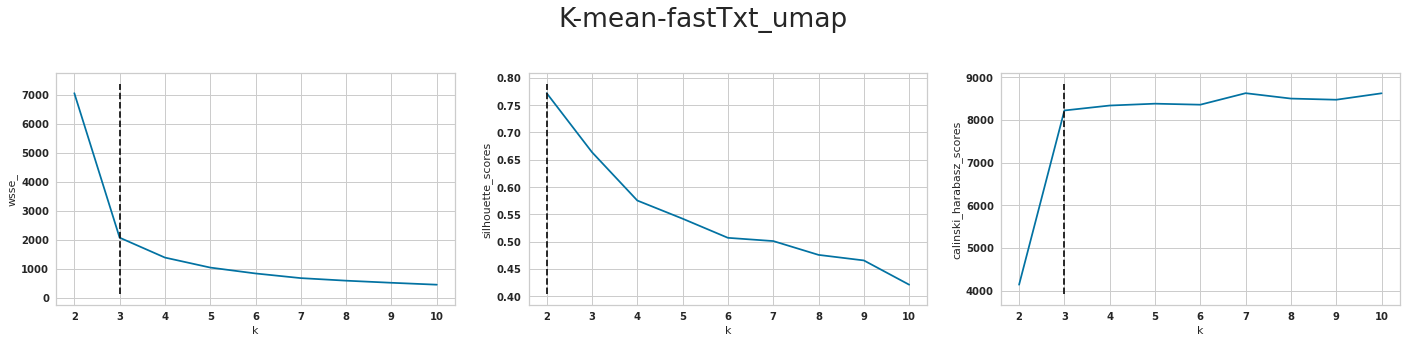

In [272]:
best_kmean = 6
obj = kmean_df.iloc[best_kmean]
plt.figure(figsize = (20, 5))

ax = plt.subplot(1, 3, 1)
ax.plot(range(*k_range), obj.wsse_)
ax.set_xlabel("k")
ax.set_ylabel("wsse_")
ax.vlines(obj.best_k_elbow, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed', color='k')


ax = plt.subplot(1, 3, 2)
ax.plot(range(*k_range), obj.silhouette_scores)
ax.set_xlabel("k")
ax.set_ylabel("silhouette_scores")
ax.vlines(obj.best_k_silhouette, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed', color='k')


ax = plt.subplot(1, 3, 3)
ax.plot(range(*k_range), obj.calinski_harabasz_scores)
ax.set_xlabel("k")
ax.set_ylabel("calinski_harabasz_scores")
ax.vlines(obj.best_k_calinski, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed', color='k')

plt.suptitle(obj['name'])
plt.tight_layout()

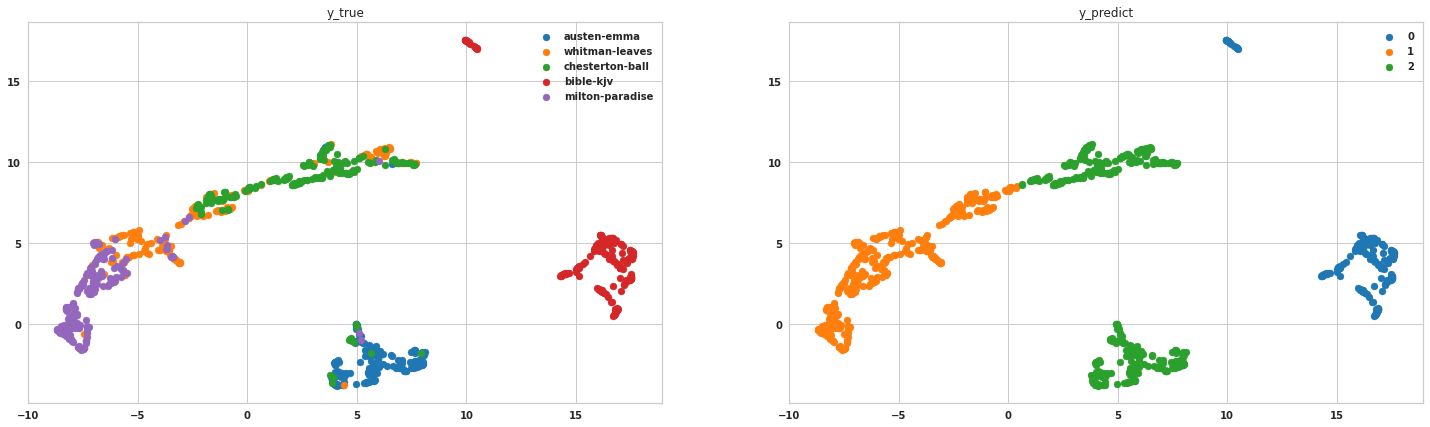

In [273]:
new_x_train = obj.pipline.fit_transform(X_train)
new_x_train_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(new_x_train)
kmeans = KMeans(n_clusters = 3, random_state = 42).fit(new_x_train)
plotClusterSpace(new_x_train_2d, y_train, kmeans.predict(new_x_train))

# EM

In [274]:
GaussianMixture_resutls = []

for exp_name, vectorizer in experments.items():
    vectorizer, dim_red = vectorizer

    vectorizer_pipline = Pipeline([
            ('vect', vectorizer),
            ('to_dense', DenseTransformer()),
            ('dim_red', dim_red),
#             ('scaller', MinMaxScaler()),
        ])

    new_x_train = vectorizer_pipline.fit_transform(X_train)
    print(f"Start: {exp_name} - {new_x_train.shape}")
    
    # get the elbow with best k
    # choose the best K,
    bics_ = []
    aics_ = []
    silhouette_scores = []
    calinski_harabasz_scores = []
    
    for i in range(*k_range):
        print(f" --- K={i}")
        model = GaussianMixture(i, covariance_type='spherical', random_state=42)
        model.fit(new_x_train)
        # bic
        bics_.append(model.bic(new_x_train))
        # aic
        aics_.append(model.aic(new_x_train))
        # silhouette
        silhouette_scores.append(silhouette_score(new_x_train, model.predict(new_x_train)))
        # calinski (Variance Ratio Criterion)
        calinski_harabasz_scores.append(calinski_harabasz_score(new_x_train, model.predict(new_x_train)))
        
        
    knee_bics = KneeLocator(range(*k_range), bics_, curve='convex', direction='decreasing')
    knee_aics = KneeLocator(range(*k_range), aics_, curve='convex', direction='decreasing')
    knee_silhouette = KneeLocator(range(*k_range), silhouette_scores, curve='concave', direction='increasing', S=1)
    knee_calinski = KneeLocator(range(*k_range), calinski_harabasz_scores, curve='concave', direction='increasing', S=1)    
    
    result_ = {"name": f"EM-{exp_name}",
               "vec_shape": new_x_train.shape,
               "bic_score": bics_[knee_bics.knee-k_range[0]],
               "best_k_bic": knee_bics.knee,
               "bics_": bics_,
               
               "aic_score": aics_[knee_aics.knee-k_range[0]],
               "best_k_aic": knee_aics.knee,
               "aics_": aics_,
               
               "silhouette": silhouette_scores[knee_silhouette.knee-k_range[0]],
               "best_k_silhouette": knee_silhouette.knee,
               "silhouette_scores": silhouette_scores,
               
               "calinski": calinski_harabasz_scores[knee_calinski.knee-k_range[0]],
               "best_k_calinski": knee_calinski.knee,
               "calinski_harabasz_scores": calinski_harabasz_scores,
               
               "pipline": vectorizer_pipline
              }

    GaussianMixture_resutls.append(result_)
    

Start: bow_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: tfidf_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: bow-n-gram_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: tfidf-n-gram_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: glove_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: word2vec_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: fastTxt_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10


In [275]:
GaussianMixture_df = pd.DataFrame(GaussianMixture_resutls)
GaussianMixture_df

,name,vec_shape,bic_score,best_k_bic,bics_,aic_score,best_k_aic,aics_,silhouette,best_k_silhouette,silhouette_scores,calinski,best_k_calinski,calinski_harabasz_scores,pipline
0,EM-bow_umap,"(1000, 10)",4966.411379,5,"[10037.896922251573, 7382.804314836598, 5945.4...",4676.853818,5,"[9925.018550834984, 7211.032880072223, 5714.81...",0.503459,2,"[0.5034594, 0.39856347, 0.3776195, 0.29717737,...",1037.948402,2,"[1037.9484015759579, 866.9322012685572, 716.77...","(CountVectorizer(), <__main__.DenseTransformer..."
1,EM-tfidf_umap,"(1000, 10)",3406.235581,5,"[17341.09939979871, 9639.456243441216, 5768.41...",3116.678020,5,"[17228.221028382122, 9467.684808676842, 5537.7...",0.567237,2,"[0.56723666, 0.5855176, 0.5489398, 0.53888166,...",3727.140743,5,"[1952.6161036452477, 2867.4423209169477, 3265....","(TfidfVectorizer(max_df=0.7, stop_words='engli..."
2,EM-bow-n-gram_umap,"(1000, 10)",4791.563754,5,"[9124.163400974621, 7743.5582571928835, 5941.9...",4502.006192,5,"[9011.285029558032, 7571.7868224285085, 5711.3...",0.284044,2,"[0.28404433, 0.23972547, 0.272149, 0.3128153, ...",406.957435,2,"[406.9574351577542, 358.1474023708473, 375.539...","(CountVectorizer(max_df=0.7, ngram_range=(2, 2..."
3,EM-tfidf-n-gram_umap,"(1000, 10)",5773.827906,4,"[11416.30758682934, 7002.156216761142, 5773.82...",5543.163408,4,"[11303.42921541275, 6830.384781996767, 5543.16...",0.401408,2,"[0.40140805, 0.4166718, 0.33813074, 0.33216953...",1171.137280,3,"[959.1189333697491, 1171.137279688209, 1005.94...","(TfidfVectorizer(max_df=0.7, ngram_range=(2, 2..."
4,EM-glove_umap,"(1000, 10)",6874.854046,4,"[18620.650539352242, 12651.747824202548, 6874....",6644.189548,4,"[18507.772167935655, 12479.976389438174, 6644....",0.636421,2,"[0.6364207, 0.5246763, 0.5578293, 0.48528722, ...",3799.021966,4,"[2593.682552519637, 2614.9150806190232, 3799.0...",(CustomVectorizer(model=<gensim.models.keyedve...
5,EM-word2vec_umap,"(1000, 10)",7570.762121,4,"[19718.549513759262, 13206.262084994683, 7570....",7340.097623,4,"[19605.671142342675, 13034.49065023031, 7340.0...",0.604721,2,"[0.604721, 0.52372754, 0.5458911, 0.49083447, ...",3719.559882,4,"[2430.508580498688, 2549.3866194132165, 3719.5...",(CustomVectorizer(model=<gensim.models.keyedve...
6,EM-fastTxt_umap,"(1000, 10)",11466.142222,4,"[24582.58219993254, 14959.668520946187, 11466....",11235.477724,4,"[24469.703828515954, 14787.897086181812, 11235...",0.771957,2,"[0.7719568, 0.6638606, 0.58238184, 0.5426227, ...",8218.903619,3,"[4142.140283366364, 8218.903619172333, 8282.81...",(CustomVectorizer(model=<gensim.models.keyedve...


In [519]:
GaussianMixture_df[['name', 'vec_shape', 'bic_score', 'best_k_bic', 'aic_score', 'best_k_aic', 'silhouette', 'best_k_silhouette', 'calinski', 'best_k_calinski']]


,name,vec_shape,bic_score,best_k_bic,aic_score,best_k_aic,silhouette,best_k_silhouette,calinski,best_k_calinski
0,EM-bow_umap,"(1000, 10)",4966.411379,5,4676.853818,5,0.503459,2,1037.948402,2
1,EM-tfidf_umap,"(1000, 10)",3406.235581,5,3116.678020,5,0.567237,2,3727.140743,5
2,EM-bow-n-gram_umap,"(1000, 10)",4791.563754,5,4502.006192,5,0.284044,2,406.957435,2
3,EM-tfidf-n-gram_umap,"(1000, 10)",5773.827906,4,5543.163408,4,0.401408,2,1171.137280,3
4,EM-glove_umap,"(1000, 10)",6874.854046,4,6644.189548,4,0.636421,2,3799.021966,4
5,EM-word2vec_umap,"(1000, 10)",7570.762121,4,7340.097623,4,0.604721,2,3719.559882,4
6,EM-fastTxt_umap,"(1000, 10)",11466.142222,4,11235.477724,4,0.771957,2,8218.903619,3


## FastText Embedding with UMAP dimensionality reduction got the highest **silhouette**, **calinski** and lowest **BIC**, and lowest **AIC**

Text(0.5, 0.98, 'EM-fastTxt_umap')

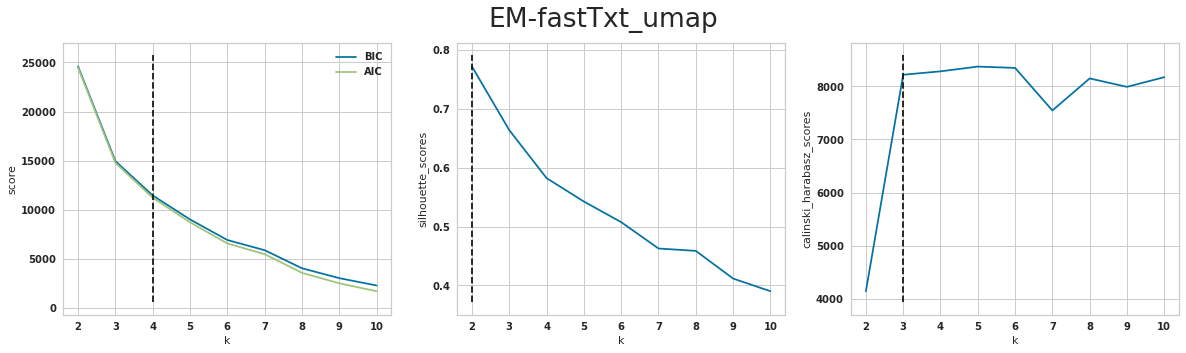

In [277]:
best_em = 6
obj = GaussianMixture_df.iloc[best_em]
plt.figure(figsize = (20, 5))

ax = plt.subplot(1, 3, 1)
ax.plot(range(*k_range), obj.bics_, label="BIC")
ax.plot(range(*k_range), obj.aics_, label="AIC")
ax.set_xlabel("k")
ax.set_ylabel("score")
ax.legend()
ax.vlines(obj.best_k_bic, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed', color='k')

ax = plt.subplot(1, 3, 2)
ax.plot(range(*k_range), obj.silhouette_scores)
ax.set_xlabel("k")
ax.set_ylabel("silhouette_scores")
ax.vlines(obj.best_k_silhouette, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed', color='k')


ax = plt.subplot(1, 3, 3)
ax.plot(range(*k_range), obj.calinski_harabasz_scores)
ax.set_xlabel("k")
ax.set_ylabel("calinski_harabasz_scores")
ax.vlines(obj.best_k_calinski, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed', color='k')

plt.suptitle(obj['name'])

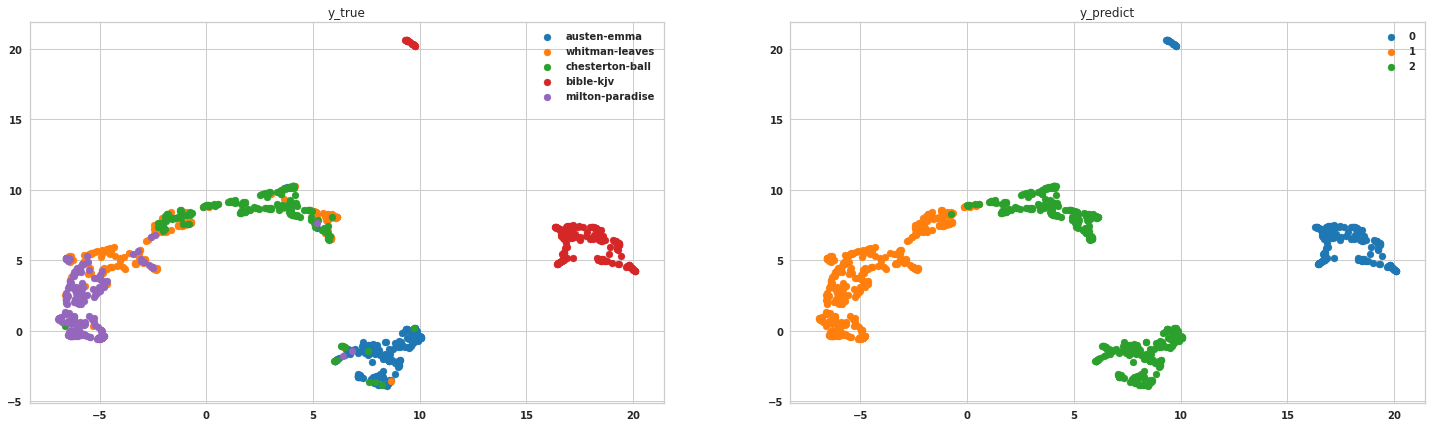

In [278]:
new_x_train = obj.pipline.fit_transform(X_train)
new_x_train_2d = umap.UMAP(n_components=2).fit_transform(new_x_train)
model = GaussianMixture(3, covariance_type='full', random_state=42).fit(new_x_train)
plotClusterSpace(new_x_train_2d, y_train, model.predict(new_x_train))

# Hierarchical clustering 

In [279]:
Hierarchical_resutls = []

for exp_name, vectorizer in experments.items():
    vectorizer, dim_red = vectorizer

    vectorizer_pipline = Pipeline([
            ('vect', vectorizer),
            ('to_dense', DenseTransformer()),
            ('dim_red', dim_red),
            ('scaller', MinMaxScaler()),
        ])

    new_x_train = vectorizer_pipline.fit_transform(X_train)
    print(f"Start: {exp_name} - {new_x_train.shape}")
    
    # get the elbow with best k
    # choose the best K,
    silhouette_scores = []
    calinski_harabasz_scores = []
    
    for i in range(*k_range):
        print(f" --- K={i}")
        model = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage = 'ward')
        # silhouette
        silhouette_scores.append(silhouette_score(new_x_train, model.fit_predict(new_x_train)))
        # calinski (Variance Ratio Criterion)
        calinski_harabasz_scores.append(calinski_harabasz_score(new_x_train, model.fit_predict(new_x_train)))
        
        
    knee_silhouette = KneeLocator(range(*k_range), silhouette_scores, curve='concave', direction='increasing', S=1)
    knee_calinski = KneeLocator(range(*k_range), calinski_harabasz_scores, curve='concave', direction='increasing', S=1)
    
    
    result_ = {"name": f"Hierarchical-{exp_name}",
               "vec_shape": new_x_train.shape,
               
               "silhouette": silhouette_scores[knee_silhouette.knee-k_range[0]],
               "best_k_silhouette": knee_silhouette.knee,
               "silhouette_scores": silhouette_scores,
               
               "calinski": calinski_harabasz_scores[knee_calinski.knee-k_range[0]],
               "best_k_calinski": knee_calinski.knee,
               "calinski_harabasz_scores": calinski_harabasz_scores,
               
               "pipline": vectorizer_pipline
              }

    Hierarchical_resutls.append(result_)
    

Start: bow_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: tfidf_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: bow-n-gram_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: tfidf-n-gram_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: glove_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: word2vec_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10
Start: fastTxt_umap - (1000, 10)
 --- K=2
 --- K=3
 --- K=4
 --- K=5
 --- K=6
 --- K=7
 --- K=8
 --- K=9
 --- K=10


In [284]:
Hierarchical_df = pd.DataFrame(Hierarchical_resutls)
Hierarchical_df

,name,vec_shape,silhouette,best_k_silhouette,silhouette_scores,calinski,best_k_calinski,calinski_harabasz_scores,pipline
0,Hierarchical-bow_umap,"(1000, 10)",0.393299,2,"[0.39329854, 0.33416745, 0.33661896, 0.2827573...",655.438782,2,"[655.4387822959369, 549.3704799965017, 487.237...","(CountVectorizer(), <__main__.DenseTransformer..."
1,Hierarchical-tfidf_umap,"(1000, 10)",0.559137,2,"[0.5591371, 0.5202589, 0.45315003, 0.48577845,...",1990.313745,3,"[1298.674730877329, 1990.313744568103, 1859.29...","(TfidfVectorizer(max_df=0.7, stop_words='engli..."
2,Hierarchical-bow-n-gram_umap,"(1000, 10)",0.263297,5,"[0.22348617, 0.23356494, 0.24659543, 0.2632970...",332.026312,2,"[332.02631179637433, 314.1374553833049, 306.46...","(CountVectorizer(max_df=0.7, ngram_range=(2, 2..."
3,Hierarchical-tfidf-n-gram_umap,"(1000, 10)",0.387339,2,"[0.3873386, 0.35310584, 0.2845099, 0.27606493,...",778.559201,3,"[678.3220089374626, 778.5592013541478, 629.880...","(TfidfVectorizer(max_df=0.7, ngram_range=(2, 2..."
4,Hierarchical-glove_umap,"(1000, 10)",0.504256,2,"[0.5042564, 0.4547753, 0.43454304, 0.39330342,...",1221.472043,3,"[1011.1734731633524, 1221.4720425303838, 1236....",(CustomVectorizer(model=<gensim.models.keyedve...
5,Hierarchical-word2vec_umap,"(1000, 10)",0.530212,2,"[0.5302119, 0.4814533, 0.408716, 0.40133893, 0...",1577.989317,3,"[1166.308565938934, 1577.989316872893, 1487.66...",(CustomVectorizer(model=<gensim.models.keyedve...
6,Hierarchical-fastTxt_umap,"(1000, 10)",0.587057,3,"[0.51623094, 0.5870571, 0.532455, 0.5023623, 0...",2462.740998,6,"[1445.1110332926282, 2066.662245927249, 2092.3...",(CustomVectorizer(model=<gensim.models.keyedve...


In [520]:
Hierarchical_df[['name', 'vec_shape', 'silhouette', 'best_k_silhouette', 'calinski', 'best_k_calinski']]

,name,vec_shape,silhouette,best_k_silhouette,calinski,best_k_calinski
0,Hierarchical-bow_umap,"(1000, 10)",0.393299,2,655.438782,2
1,Hierarchical-tfidf_umap,"(1000, 10)",0.559137,2,1990.313745,3
2,Hierarchical-bow-n-gram_umap,"(1000, 10)",0.263297,5,332.026312,2
3,Hierarchical-tfidf-n-gram_umap,"(1000, 10)",0.387339,2,778.559201,3
4,Hierarchical-glove_umap,"(1000, 10)",0.504256,2,1221.472043,3
5,Hierarchical-word2vec_umap,"(1000, 10)",0.530212,2,1577.989317,3
6,Hierarchical-fastTxt_umap,"(1000, 10)",0.587057,3,2462.740998,6


## FastText Embedding with UMAP dimensionality reduction got the highest **silhouette**, **calinski**

Text(0.5, 0.98, 'Hierarchical-fastTxt_umap')

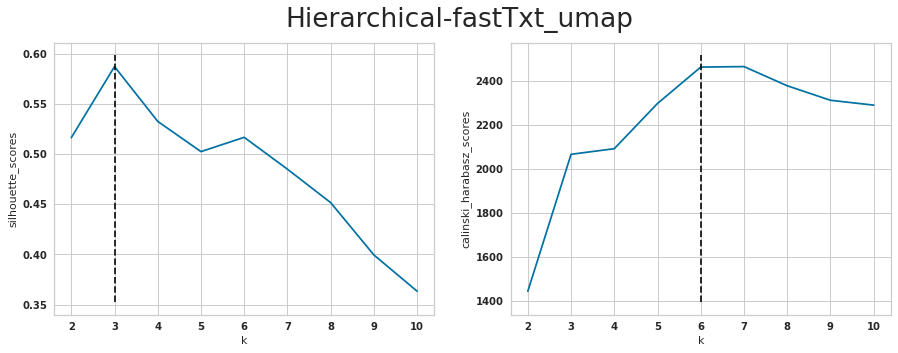

In [285]:
best_hir = 6
obj = Hierarchical_df.iloc[best_hir]
plt.figure(figsize = (15, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(range(*k_range), obj.silhouette_scores)
ax.set_xlabel("k")
ax.set_ylabel("silhouette_scores")
ax.vlines(obj.best_k_silhouette, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed', color='k')


ax = plt.subplot(1, 2, 2)
ax.plot(range(*k_range), obj.calinski_harabasz_scores)
ax.set_xlabel("k")
ax.set_ylabel("calinski_harabasz_scores")
ax.vlines(obj.best_k_calinski, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed', color='k')

plt.suptitle(obj['name'])

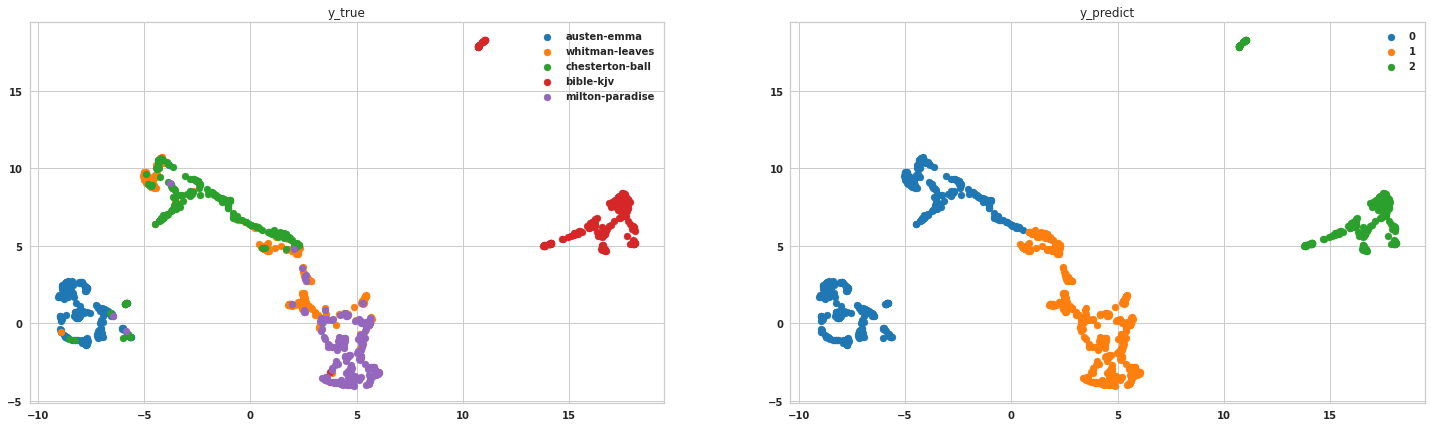

In [286]:
new_x_train = obj.pipline.fit_transform(X_train)
new_x_train_2d = umap.UMAP(n_components=2).fit_transform(new_x_train)
model = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')
plotClusterSpace(new_x_train_2d, y_train, model.fit_predict(new_x_train))


## Choose the winner model, that success to cluster the data with highest separability and will chosen based
1. maximized the number of clusters (k=3)
2. maximized the silhouette_score & calinski_harabasz_scores

<AxesSubplot:>

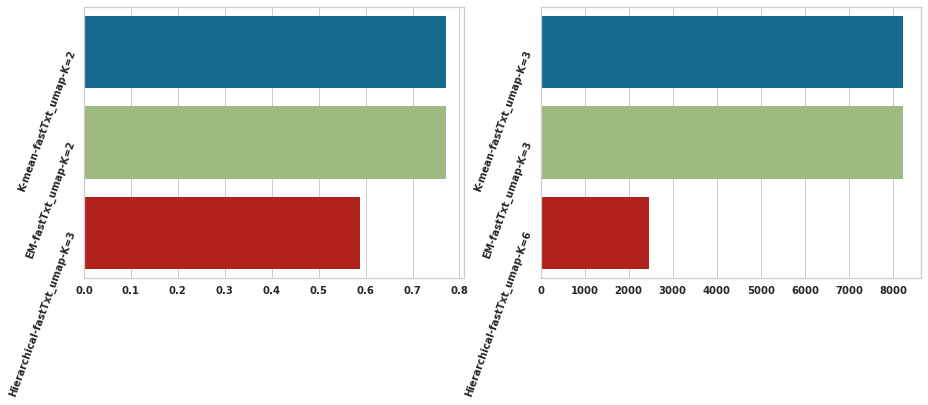

In [527]:
objs = [ kmean_df.iloc[best_kmean], GaussianMixture_df.iloc[best_em], Hierarchical_df.iloc[best_hir] ]
xx1 = [i['silhouette'] for i in objs]
xx2 = [i['calinski'] for i in objs]
yy1 = [f"{i['name']}-K={i.best_k_silhouette}" for i in objs] 
yy2 = [f"{i['name']}-K={i.best_k_calinski}" for i in objs]
plt.figure(figsize = (15, 5))
ax = plt.subplot(1, 2, 1)
ax.tick_params(axis='y', rotation=70)
sns.barplot(x=xx1, y=yy1, ax=ax)
ax = plt.subplot(1, 2, 2)
ax.tick_params(axis='y', rotation=70)
sns.barplot(x=xx2, y=yy2, ax=ax)

## According to the results, we will choose K-means as best model, because it has the same silhouette and highest calinski, and we will choose K=3 as the best, because the silhouette will not decrease too much.

# KAPPA

In [350]:
new_x_train = kmean_df.iloc[best_kmean].pipline.fit_transform(X_train)

In [351]:
vectorizer_pipline = Pipeline([
            ('vect', CustomVectorizer(model=fastTxt)),
            ('to_dense', DenseTransformer()),
            ('dim_red', dim_red),
        ])

new_x_train = vectorizer_pipline.fit_transform(X_train)
y_train_labels = y_train.factorize()

In [364]:
kappas = {}

for k in range(*k_range):
    model = KMeans(n_clusters=k, random_state=42).fit(new_x_train)
    kappas[f"kmean-k={k}"] = cohen_kappa_score(model.predict(new_x_train), y_train_labels[0])
    
    model = GaussianMixture(k, covariance_type='spherical', random_state=42).fit(new_x_train)
    kappas[f"EM-k={k}"] =  cohen_kappa_score(model.predict(new_x_train), y_train_labels[0])
    
    model = AgglomerativeClustering(n_clusters=k, affinity = 'euclidean', linkage = 'ward').fit(new_x_train)
    kappas[f"Hierarchical-k={k}"] = cohen_kappa_score(model.fit_predict(new_x_train), y_train_labels[0])            



In [373]:
print('Kappa of k-means with k=3 :: ', kappas['kmean-k=3'])
print('highst Kappa with :: ', sorted(kappas.items(), key=lambda x: x[1])[-1])

Kappa of k-means with k=3 ::  0.36
highst Kappa with ::  ('Hierarchical-k=5', 0.5175000000000001)


<AxesSubplot:>

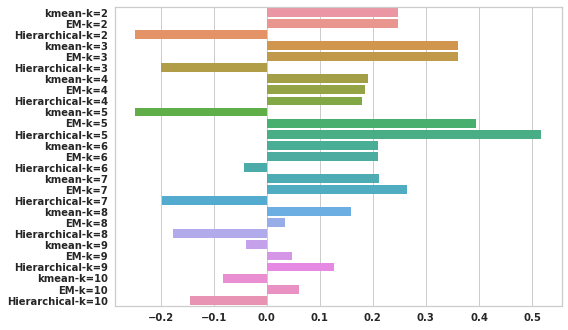

In [368]:
sns.barplot(x=list(kappas.values()), y=list(kappas.keys()))

## K-means with 3 achives 0.36 with Kappa measurement, but the highest Kappa achived by Hierarchical with k=5, but we still dealing with k-means K=3

/Users/umer/miniforge3/envs/ml/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/Users/umer/miniforge3/envs/ml/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


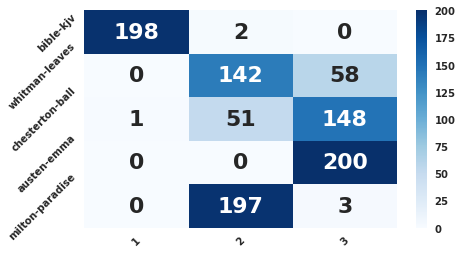

In [532]:
best_kmean_model = KMeans(n_clusters=3, random_state=42).fit(new_x_train)
plotConfMat2(y_train_labels[0],
             best_kmean_model.predict(new_x_train),
             true_labels=list(y_train_labels[1]),
             predict_labels=range(1, len(set(best_kmean_model.labels_))+1))

In [533]:
all_books_names

['bible-kjv',
 'whitman-leaves',
 'chesterton-ball',
 'austen-emma',
 'milton-paradise']

## From the confusion matrix above, there are some clusters that contain different books, which means those books were written in the same context because the FastText embedding was used and it's a contextual embedding, and the authors use the same lingo or same latent meaning to express their ideas.

## E.g clusters 1 and 2, but cluster 0, didn't overlap because it has a religious book.

## Another consideration, we already know that we have 5 books with different genres, and the number of clusters should be 5, and best k was just 3, according to model perspective, and we can't claim that this observation is wrong because here the cluster using the latent similarity which indistinct for humans, so that may be correct.

# Appling the LDA-topic modeling

In [414]:
# Create a dictionary representation of the documents.
book_doc = X_train.map(lambda x:x.lower().split())
dictionary = Dictionary(book_doc)
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in book_doc]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 10347
Number of documents: 1000


In [415]:
from tqdm import tqdm

def getLDA_Model(num_topics, dictionary, corpus):
    # Set training parameters.
    chunksize = 2000
    passes = 40
    iterations = 1000
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    temp = dictionary[0]

    model = LdaModel(
        corpus=corpus,
        id2word=dictionary.id2token,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,)
    
    return model

coherences = []
for i in tqdm(range(*k_range)):
    model = getLDA_Model(i, dictionary, corpus)
    cm = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherences.append(cm.get_coherence())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:00<00:00,  6.76s/it]


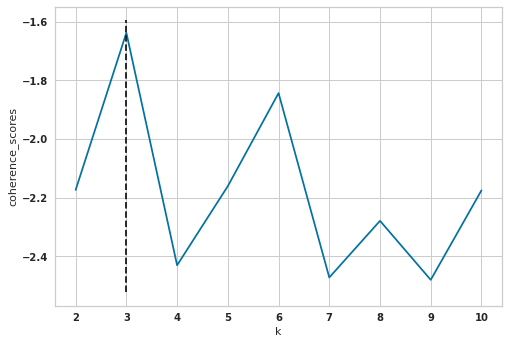

In [416]:
knee_coherences = KneeLocator(range(*k_range), coherences, curve='concave', direction='increasing', S=1)
plt.plot(range(*k_range), coherences)
plt.xlabel("k")
plt.ylabel("coherence_scores")
plt.vlines(knee_coherences.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='k')

## The best K-topics according to Coherence_score is 3

In [417]:
lda_model = getLDA_Model(3, dictionary, corpus)

In [421]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.062063  0.085171       1        1  47.318681
1     -0.095953 -0.073805       2        1  28.920956
0      0.158015 -0.011365       3        1  23.760364, topic_info=          Term        Freq       Total Category  logprob  loglift
246      shall  539.000000  539.000000  Default  30.0000  30.0000
36        unto  265.000000  265.000000  Default  29.0000  29.0000
111       lord  250.000000  250.000000  Default  28.0000  28.0000
5944  turnbull  194.000000  194.000000  Default  27.0000  27.0000
83        thou  367.000000  367.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
4        bring   67.891435  134.872770   Topic3  -5.4685   0.7507
98       child   60.742964  107.398912   Topic3  -5.5798   0.8673
14        hand   66.712998  176.889818   Topic3  -5.4861   0.4620
161      thing   66.835315  250.862364   Topic3  -5.4842   0.1145
138     father   55.879525  131.708826   Topic3  -5.6633   0.5798

[236 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.015298     10
0         3  0.979087     10
283       2  0.029471     11
283       3  0.972556     11
91        3  0.978541     12
...     ...       ...    ...
165       1  0.131234     ye
165       3  0.864954     ye
191       1  0.426009  young
191       2  0.407487  young
191       3  0.175960  young

[386 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

## Apply Error Analysis, and get what confuse the models

In [488]:
def getMostCommonWords(books, X, y):
    import collections

    common_words = set()
    counters = []
    for b in books:
        all_words = sum(list(X[ y == b].map(lambda x: x.split())), [])
        if len(common_words) == 0:
            common_words = set(all_words)
        else:
            common_words = words.intersection(set(all_words))

        word_counter = collections.Counter(all_words)
        counters.append(word_counter)
    
    data = []
    for w in common_words:
        loc_arr = [w]
        for coun in counters:
            loc_arr += [coun[w]]
        data.append(loc_arr)

    data = sorted(data, key=lambda x: sum(x[1:]), reverse=True)
    most_common = pd.DataFrame(data, columns=['word']+books)
    return most_common

In [489]:
getMostCommonWords(['whitman-leaves', 'austen-emma', 'chesterton-ball'], X_train, y_train).head(10)

,word,whitman-leaves,austen-emma,chesterton-ball
0,man,117,54,181
1,think,43,125,72
2,come,68,78,82
3,know,48,100,79
4,like,36,36,129
5,look,41,66,78
6,thing,28,87,60
7,day,92,61,15
8,good,44,83,38
9,little,25,82,47


## Here are the most common words that caused the overlapping within cluster 3

In [492]:
getMostCommonWords(['milton-paradise', 'whitman-leaves', 'chesterton-ball'], X_train, y_train).head(10)

,word,milton-paradise,whitman-leaves,chesterton-ball
0,man,87,117,181
1,shall,120,78,21
2,like,40,36,129
3,know,59,48,79
4,come,32,68,82
5,day,73,92,15
6,long,53,59,44
7,good,69,44,38
8,look,27,41,78
9,great,63,53,29


## Here are the most common words that caused the overlapping within cluster 2

In [ ]:
# 1- Preprocessing and Data Cleansing
# 2- Feature Engineering (BOW, TF-IDF, BOW-n-gram, TFIDF-n-gram, Glove, Word2Vec, FastTxt)
# 3- Modeling K-means, EM, Hierarchical clustering algorithms, and choose the best k
# 4- Perform Evaluations using (Calculate Kappa against true authors, Coherence and Silhouette) 
#    and some other metrics
# 5- Compare and decide which clustering result is the closest to the human labels,
#    using Some mesurements and viualization
# 6- Perform Error Analysis

In [ ]:
# emotinal arces

In [362]:
# model.get_document_topics(corpus)

# References

* https://aclanthology.org/W15-0705.pdf
* https://mirror-medium.com/?m=https%3A%2F%2Fmedium.com%2F%40haataa%2Fhow-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c
* 
